In [1]:
import numpy as np
import pandas as pd # for dataframe and CSV handling
import argparse

from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import matthews_corrcoef, roc_auc_score, r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

try:
    import rdkit.Chem.Descriptors as Descriptors
    import rdkit.Chem as Chem
    from cliques.cliques import get_clique_decomposition

    has_rdkit = True
except:
    has_rdkit = False
    raise


import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import seaborn as sns

In [2]:
plt.rcParams.update({'font.size': 24})
cmap_discrete = sns.color_palette('colorblind', 10)
cmap_continuous = sns.dark_palette("#69d", reverse=True, as_cmap=True)

In [3]:
data = pd.read_csv('B3DB/B3DB_classification_clean.csv')
data_moleculenet = pd.read_csv('./moleculenet/BBBP_clean.csv')

smiles = data.SMILES

y = (data['BBB+/BBB-'] == 'BBB+').to_numpy().astype(np.int32)

In [4]:
print('Computing clique decomposition')

cliques, vocab = get_clique_decomposition(smiles)
X = cliques.to_numpy().astype(int)

Computing clique decomposition


In [5]:
df = pd.DataFrame(columns=['MolWt', 'LogP', 'CountsDataset', 'CountsMolecule', 'P(BBB+)'], index=vocab)
print(df)

                                                   MolWt LogP CountsDataset  \
S                                                    NaN  NaN           NaN   
C1CNC2CCCC(C1)C2                                     NaN  NaN           NaN   
C1CCCC2CCC3OC4C5OC6(CCC7CCC(CCC8CCCC(CC1)O8)O7)...   NaN  NaN           NaN   
C1=NCCC=[NH+]C1                                      NaN  NaN           NaN   
C1=CSCCN1                                            NaN  NaN           NaN   
...                                                  ...  ...           ...   
CF                                                   NaN  NaN           NaN   
C1CCNCCNCCNCCNCCNCCNCCNC1                            NaN  NaN           NaN   
C1CC2CNC(C1)C2                                       NaN  NaN           NaN   
C1CNCCNCCNCCNCCNCCNCCN1                              NaN  NaN           NaN   
C1=CCNC1                                             NaN  NaN           NaN   

                                                   

In [6]:
df['MolWt'][vocab] = [Chem.Descriptors.MolWt(Chem.MolFromSmiles(s)) for s in vocab]
df['LogP'][vocab] = [Chem.Descriptors.MolLogP(Chem.MolFromSmiles(s)) for s in vocab]
print(df)

                                                      MolWt    LogP  \
S                                                    34.083  0.1128   
C1CNC2CCCC(C1)C2                                    139.242  1.9286   
C1CCCC2CCC3OC4C5OC6(CCC7CCC(CCC8CCCC(CC1)O8)O7)...  532.718  5.3527   
C1=NCCC=[NH+]C1                                      97.141 -1.3877   
C1=CSCCN1                                           101.174   0.794   
...                                                     ...     ...   
CF                                                   34.033  0.5857   
C1CCNCCNCCNCCNCCNCCNCCNC1                           329.537 -2.0926   
C1CC2CNC(C1)C2                                      111.188  1.1484   
C1CNCCNCCNCCNCCNCCNCCN1                             301.483 -2.8728   
C1=CCNC1                                             69.107  0.1458   

                                                   CountsDataset  \
S                                                            NaN   
C1CNC2CCCC(

In [7]:
df['CountsDataset'][vocab] = (X > 0).sum(axis=0)
df['CountsMolecule'][vocab] = X.mean(axis=0)
print(df)

                                                      MolWt    LogP  \
S                                                    34.083  0.1128   
C1CNC2CCCC(C1)C2                                    139.242  1.9286   
C1CCCC2CCC3OC4C5OC6(CCC7CCC(CCC8CCCC(CC1)O8)O7)...  532.718  5.3527   
C1=NCCC=[NH+]C1                                      97.141 -1.3877   
C1=CSCCN1                                           101.174   0.794   
...                                                     ...     ...   
CF                                                   34.033  0.5857   
C1CCNCCNCCNCCNCCNCCNCCNC1                           329.537 -2.0926   
C1CC2CNC(C1)C2                                      111.188  1.1484   
C1CNCCNCCNCCNCCNCCNCCN1                             301.483 -2.8728   
C1=CCNC1                                             69.107  0.1458   

                                                   CountsDataset  \
S                                                            481   
C1CNC2CCCC(

In [8]:
# Warning, I would only look at the P(BBB+) for the very commonly occuring cliques.
# The P(BBB+) is a numerical estimate.
# The accuracy will drop off quite dramatically as the sample size decreases
# Although I've not formally run through a proof, I'm fairly certain that this estimate is equivalent to a maximum likelihood estimate
# This means our estimate should have sample variance proportional to 1/(N-1)
# So if our sample size is 1, our sample variance is infinite!

X_present = (X > 0).astype(np.float32)

clf = BernoulliNB().fit(X_present, y)
logpx_y = clf.feature_log_prob_[1]
logpx = np.log(np.exp(clf.feature_log_prob_[0]) * (1 - np.mean(y)) + np.exp(clf.feature_log_prob_[1]) * np.mean(y))
logpy_x = logpx_y + np.log(np.mean(y)) - logpx
py_x = np.exp(logpy_x)

df['P(BBB+)'][vocab] = py_x

print(df)

df.to_csv('clique_statistics.csv')

                                                      MolWt    LogP  \
S                                                    34.083  0.1128   
C1CNC2CCCC(C1)C2                                    139.242  1.9286   
C1CCCC2CCC3OC4C5OC6(CCC7CCC(CCC8CCCC(CC1)O8)O7)...  532.718  5.3527   
C1=NCCC=[NH+]C1                                      97.141 -1.3877   
C1=CSCCN1                                           101.174   0.794   
...                                                     ...     ...   
CF                                                   34.033  0.5857   
C1CCNCCNCCNCCNCCNCCNCCNC1                           329.537 -2.0926   
C1CC2CNC(C1)C2                                      111.188  1.1484   
C1CNCCNCCNCCNCCNCCNCCN1                             301.483 -2.8728   
C1=CCNC1                                             69.107  0.1458   

                                                   CountsDataset  \
S                                                            481   
C1CNC2CCCC(

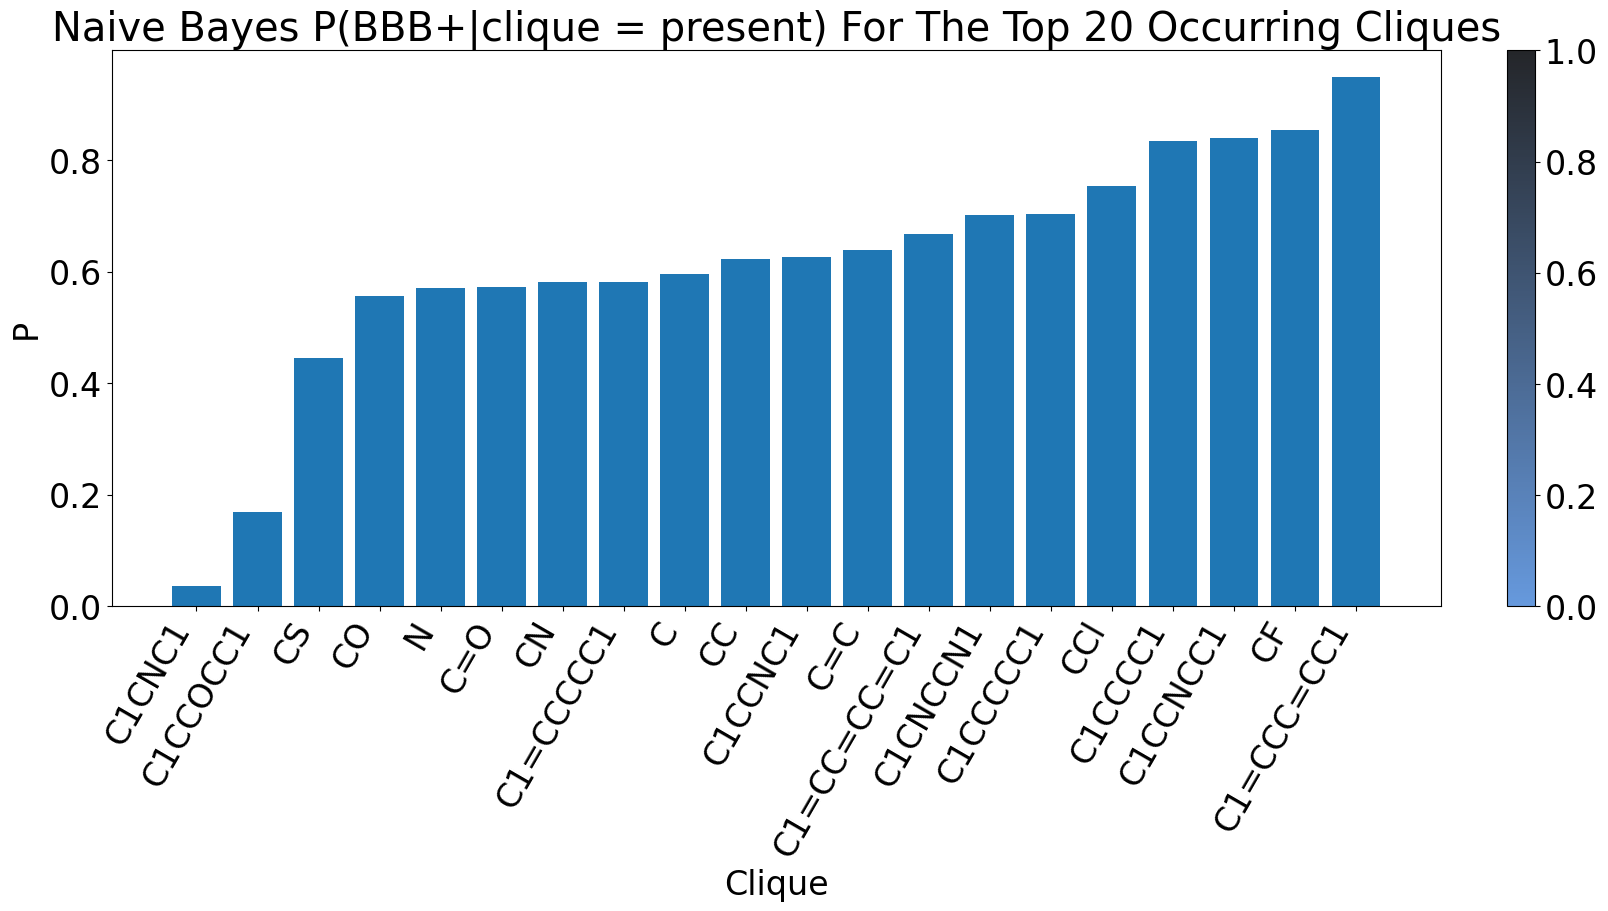

In [9]:
# This is mostly for sanity checking against our other notebooks

idx_selected = np.argsort(df['CountsDataset'])[-20:].to_list()
py_x = np.array(py_x)[idx_selected]
vocab_selected = np.array(vocab)[idx_selected]

order = np.argsort(py_x)
vocab_selected = vocab_selected[order]
py_x = py_x[order]

fig, ax = plt.subplots(figsize=(16, 9), layout='constrained')
bar = ax.bar(np.arange(len(py_x)), py_x, width=0.8)
ax.set_title('Naive Bayes P(BBB+|clique = present) For The Top 20 Occurring Cliques')
ax.set_ylabel('P')
ax.set_xticks(np.arange(len(py_x)), vocab_selected, rotation=60, ha='right')
ax.set_xlabel('Clique')
sm = ScalarMappable(cmap=cmap_continuous)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)